# Laboratorio 10 Detección de comunidades Parte 2

En este laboratorio continuaremos con nuestro objetivo de detectar comunidades, pero ahora ampliaremos a mecanismos que no se basan en la modularidad, evitando así sus limitaciones.


Contenidos:

1.   Algoritmo de propagación de etiquetas
2.   Información mutua normalizada
3.   Benchmarks para algoritmos de detección



In [1]:
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Algoritmo de propagación de etiquetas

Este algoritmo trata de simular la interacción entre agentes de una red social, lo que hace que sus resultados se asemejen a las comunidades que podrían generarse naturalmente. El método se describe a continuación:
Partimos con una partición en donde cada nodo se le asigna una etiqueta única, la que representa la comunidad a la que pertenece:

1. Recorremos todos los nodos del gráfico siguiendo un orden aleatorio:
  1. Cada nudo toma la etiqueta compartida por la mayoría de sus vecinos. Si existe un empate, elegimos la etiqueta de manera aleatoria entre las empatadas.
2.Si cada nodo ya posee la etiqueta de su mayoría de vecinos entonces termina el proceso. Si no, volvemos al paso 1.

Al término de este algoritmo tendremos grupos de nodos que comparten etiquetas. Este mecanismo sigue el principio de las tendencias dentro de una red social, en donde un conjunto de nodos que forman una comunidad, comunmente poseen alguna cualidad en común (representada por la etiqueta) que permite la creación y crecimiento de la comunidad.

## Partición Inicial

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

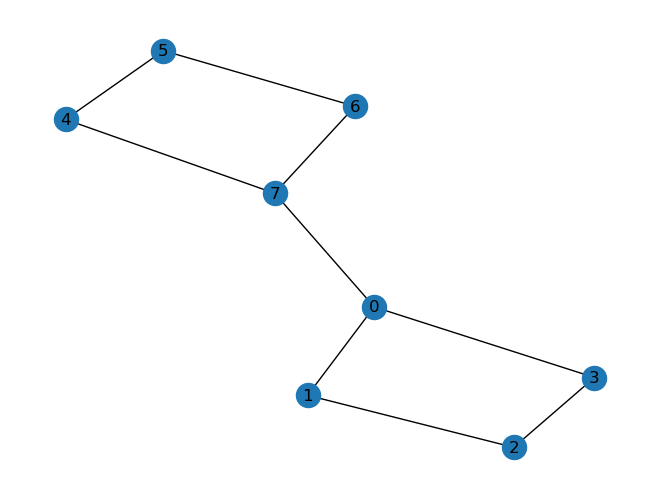

In [2]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)

# Inicializar cada nodo como su propia comunidad
def first_partition(G):
  Partition_Dict = dict()
  for i,node in enumerate(G.nodes):
    Partition_Dict[node] = i

  return Partition_Dict

communities = first_partition(G)
communities


## Recorremos los nodos en orden aleatorio cambiando las etiquetas por la mayoría de sus vecinos.

Para esto en primera instancia debemos tener realizar una función que realice el recuento de votos y elija al más repetido `moda_lista`.

A continuación, se realiza una función que cambia la etiqueta de un nodo a la vez `cambiar_etiqueta`.




In [3]:
#Función para buscar el valor más votado
def moda_lista(lista):
  valores = {valor:lista.count(valor) for valor in set(lista)}
  maximo = max(valores.values())
  modas = [k for k, v  in valores.items() if v == maximo]
  # Ante empates se elige al azar
  return random.choices(modas, k=1)[0]

#Función que dado un nodo cambia su etiqueta por votación de sus vecinos
def cambiar_etiqueta(v, G, P):
  vecinos = G.neighbors(v)
  votos = [P[veci] for veci in vecinos]
  etiqueta_v = moda_lista(votos)
  P[v] = etiqueta_v
  return P

nueva_communities = cambiar_etiqueta(1, G, communities)
nueva_communities # Cambio la etiqueta de 1
A = list(G.nodes)
print(A)
random.shuffle(A)
print(A)

[0, 1, 2, 3, 4, 5, 6, 7]
[5, 7, 0, 2, 4, 6, 1, 3]


Ahora con estas funciones podemos recorremos los nodos aleatoriamente e ir cambiando su etiqueta basado en sus vecinos.

In [4]:
def cambiar_etiquetas(G, P):

  communities = P.copy()
  A = list(G.nodes)
  random.shuffle(A)
  for v in A:
    communities = cambiar_etiqueta(v, G, communities)
  return communities


def vote_label(G):

  communities = first_partition(G)
  for _ in range(10):
    communities = cambiar_etiquetas(G, communities)

  return communities

vote_label(G)


{0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4}

Ejemplificamos con el grafo de prueba.

{0: 1, 1: 1, 2: 1, 3: 1, 4: 5, 5: 5, 6: 5, 7: 5}


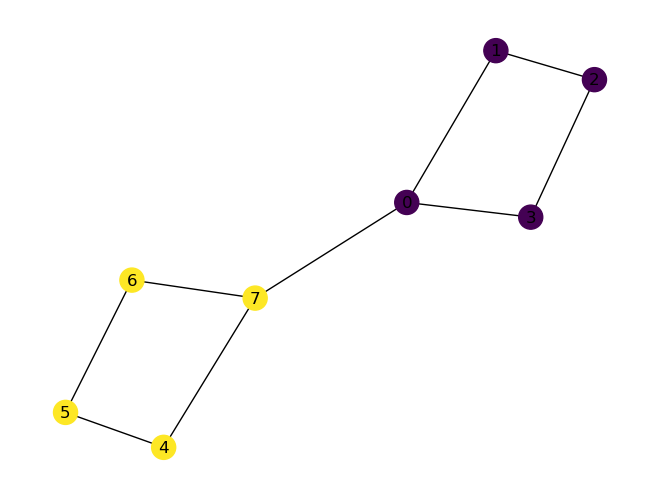

In [5]:
Partition = vote_label(G)
print(Partition)
node_colors = [Partition[n] for n in G.nodes]
nx.draw(G, with_labels=True, node_color=node_colors)

## Función NetworkX

`nx.community.label_propagation_communities(G)` generará una secuencia que contiene una partición creada por el algoritmo de propagación de etiquetas.
Hay pequeñas diferencias entre nuestra implementación y la realizada en NetworkX, por lo cual iremos comparando a lo largo del laboratorio cual de ellas tiene mejor rendimiento.

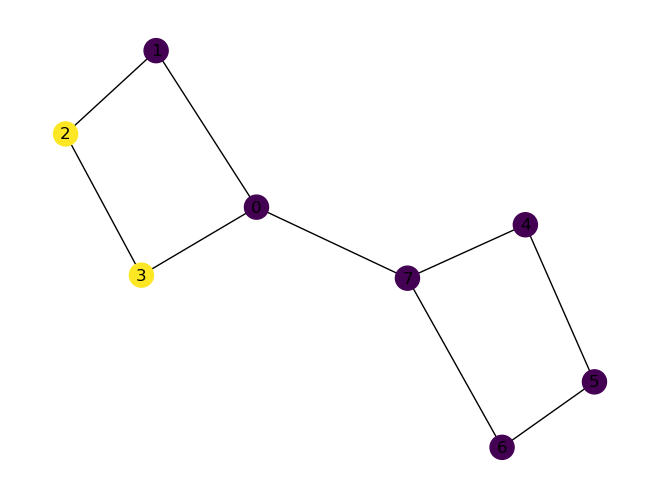

In [6]:
def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

Partition = list(nx.community.label_propagation_communities(G))
Partition_map = create_partition_map(Partition)

node_colors = [Partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

# Información mutua normalizada

Podemos comparar las particiones entregadas por un algoritmo con aquellas particiones sabemos existen dentro del benchmark. Para esto debemos definir distribuciones de probabilidad asociadas a particiones.

Dadas dos particiones $X$  e $Y$ de un grafo G, definimos la probabilidad de que un nodo seleccionado de manera aleatoria pertenezca a la comunidad $x\in X$  como : $$P(x) = \dfrac{|V(x)|}{|V(G)|}$$

Luego, para un nodo seleccionado de forma aleatoria, la probabilidad de que pertenezca a dos comunidades  $x\in X$ y $y\in Y$ al mismo tiempo se define como:
 $$P(x,y)  =  \dfrac{|V(x) \cap V(y)|}{|V(G)|}$$

 Luego definimos la información mutaa de las particiones como una medida de similaridad entre ellas como:

 $$NMI(X,Y) = \dfrac{2H(X)- 2H(X|Y)}{H(X) + H(Y)}$$
 Donde $H$ es la entropía de la distribución $P$, $$H(X) = - \sum_{x\in X} P(x)log(P(x))$$

## Calcula la Entropía

Primero creamos una función que calcule la entropia $H(X)$.

In [7]:
import numpy as np

def H(X):
  S = sum([len(x) for x in X])
  H = 0
  for x in X:
    n_x = len(x)
    P_x = n_x/S
    H += P_x * np.log(P_x)

  return -1*H


Partition1 = vote_label(G)
Partition2 = list(nx.community.label_propagation_communities(G))
print(Partition2)
H(Partition2)

[{0, 1, 4, 5, 6, 7}, {2, 3}]


0.5623351446188083

Vemos que las particiones deben estar como una lista de conjuntos, por lo tanto `group_by_value` cambia el diccionario con etiquetas al formato mencionado anteriormente.

In [8]:
def group_by_value(input_dict):
    grouped_dict = {}

    for key, value in input_dict.items():
      if value not in grouped_dict:
            grouped_dict[value] = set()
      grouped_dict[value].add(key)

    return list(grouped_dict.values())

Partition1 = group_by_value(Partition1)
print(Partition1)
H(Partition1)

[{0, 1, 2, 3}, {4, 5, 6, 7}]


0.6931471805599453

Notemos que debemos tener nuestra partición escrita de la forma P = [Conjunto1, Conjunto2,...].

## Calcula la Entropía Condicionada
Ahora creamos la función que calcula la entropía condicionada

In [9]:
def H_XY(X,Y):
  S = sum([len(x) for x in X])
  HX_Y = 0

  for x in X:
    n_x = len(x)
    P_x = n_x/S
    for y in Y:
      n_y = len(y)
      P_y = n_y/S
      n_xy = len(x & y)
      P_xy = n_xy/S
      if n_xy == 0:
        continue

      HX_Y += P_xy * np.log(P_xy/P_y)

  return -1* HX_Y


H_XY(Partition1, Partition2)

0.4773856262211097

## Calcular NMI

Finalmente con las funciones anteriores es fácil crear nuestra función que calcule la información mutua normalizada.

Veamos que si la partición $X = Y$ entonces la información mutua debe ser 1.

In [10]:
def NMI(X,Y):
  HX = H(X)
  num = 2 * HX - 2*H_XY(X,Y)
  den = HX + H(Y)

  return num/den

print(NMI(Partition1, Partition1)) # Debe dar 1 por ser la misma partición
print(NMI(Partition1, Partition2))

1.0
0.3437110184854507


# Benchmarks para algoritmos de detección
Dada la dificultad para medir la calidad de los algoritmos de detección de comunidades, se han introducido benchmarks (o comparativas) de gráficos en donde las comunidades son conocidas. De esta manera, es posible detectar casos en donde un algoritmo dado no es capaz de detectar comunidades que sabemos que existen.

## Benchmarks Reales
Cuando hablamos de benchmarks reales nos referimos a gráficos de la vida real en donde sabemos qué comunidades existen. Este tipo de gráficos permiten comparativas fieles a la realidad, sin embargo son limitados en cantidad y complejidad.
Uno de los casos más típicos es el del club de Karate de Zachary, el cual ya hemos trabajado anteriormente y ahora veremos como se comportan los algoritmos previos en este caso.

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

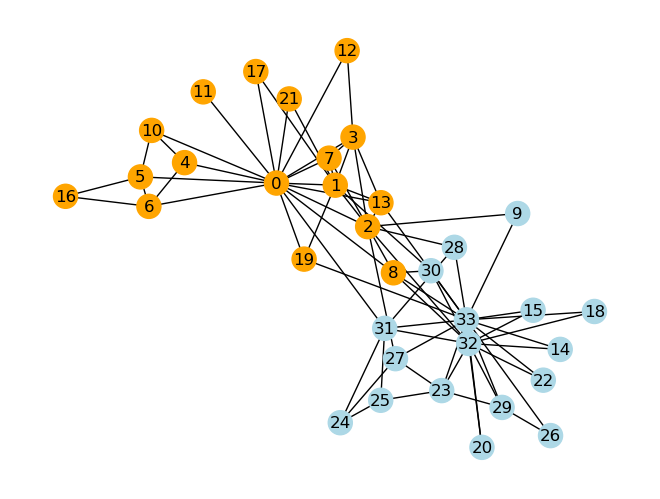

In [11]:
K = nx.karate_club_graph()
club_color = {
    'Mr. Hi': 'orange',
    'Officer': 'lightblue',
}
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]
nx.draw(K, node_color=node_colors, with_labels=True)

groups = {
    'Mr. Hi': set(),
    'Officer': set(),
}

for n in K.nodes:
    club = K.nodes[n]['club']
    groups[club].add(n)

empirical_partition = list(groups.values())
empirical_partition

## Comparación métodos anteriores



In [12]:
random.seed(123)
Partition1 = group_by_value(vote_label(K))
Partition2 = list(nx.community.label_propagation_communities(K))

print("Partición 1:",Partition1)
print("Partición 2:",Partition2)

print("NMI Partition1: ", NMI(Partition1, empirical_partition))
print("NMI Partition2: ",NMI(Partition2, empirical_partition))


Partición 1: [{0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}]
Partición 2: [{0, 1, 3, 4, 7, 10, 11, 12, 13, 17, 19, 21, 24, 25, 31}, {32, 33, 2, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30}, {16, 5, 6}]
NMI Partition1:  0.6772430411026017
NMI Partition2:  0.36359877846075617


Vemos que la partición1 tiene mejor NMI que la 2, entonces la partición 1 es mejor detectando la comunidad especificado en este gráfico.

In [13]:

modularity_sequence = [nx.community.quality.modularity(K, p) for p in nx.community.girvan_newman(K)]
## Encontramos el máximo elemento
modularidad_maxima = max(modularity_sequence)
# Encontrar el índice del elemento máximo
indice_maximo = modularity_sequence.index(modularidad_maxima)
Partition3 = list(nx.community.girvan_newman(K))[indice_maximo]

print("Partición 3:",Partition3)
print("NMI Partition3: ", NMI(Partition3, empirical_partition))

Partición 3: ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9})
NMI Partition3:  0.48514103877993775


## Benchmarks artificiales

Este tipo de benchmarks hace referencia a gráficos generados de manera aleatoria, siguiendo un modelo que crea comunidades dentro de la red. De esta manera, podemos generar múltiples instancias de distintas comunidades donde podemos probar nuestro algoritmo o mecanismo de detección de comunidades.

### LRF
A continuación se mostrará el algoritmo LFR para generar grafos aleatorios, que tienen comunidades previamente definidas según sus parámentros.

LFR el cual genera un gráfico aleatorio a partir de los siguientes parámetros:
1. N es la cantidad de nodos en el grafo
2. Tau1 es el exponente de la distribución exponencial que siguen los grados del grafo
3. Tau2 es el exponente de la distribución exponencial que siguen los tamaños de las comunidades
4. Mu es la proporción esperada de vecinos tiene un nodo en comunidades distintas a la propia

Podemos utilizar la función `nx.LFR_benchmark_graph()` para generar este tipo de grafos.

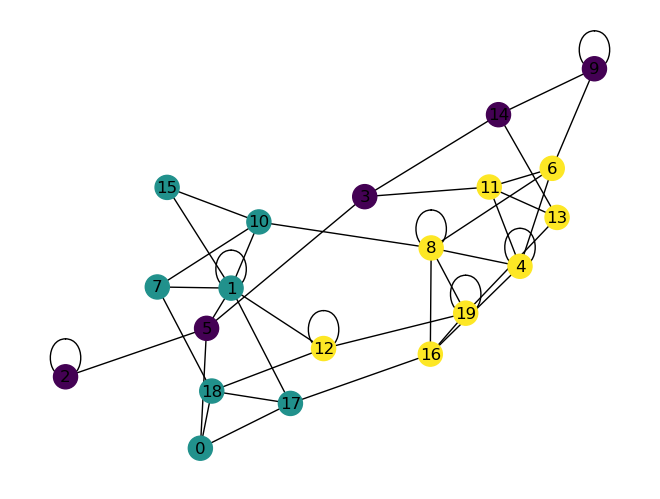

In [14]:
n = 20
tau1 = 2
tau2 = 1.1
mu = .2
G = nx.LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=4, min_community=5, seed=10
)

# Obtener asignación de comunidades
communities = nx.get_node_attributes(G, 'community')
A = list(communities.values())
# Eliminar conjuntos duplicados
conjuntos_sin_duplicados = list(set(map(frozenset, A)))
communities = [set(x) for x in conjuntos_sin_duplicados]

communities_map = create_partition_map(communities)

node_colors = [communities_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

